# DCGAN Example for Generating Handwritten Digits

DCGAN stands for Deep Convolutional Generative Adversial Network. In this example we train a GAN to produce handwritten digits using the MNIST dataset. GANs consist of two different models, namely the:

* **discriminator**
* **generator**

The discriminator model tries to detect whether the given input is real, meaning that it is a sample from the distribution of real objects, while the generator model generates data based on a given random vector, called the latent space. During training these two models are made to compete against each other, which is where the name *adversial* stems from. The discriminator model is a binary classifier that outputs 1 for real images and 0 for fakes. If the generator learns to generate data that is from the distribution of real objects, then the discriminator outputs 1 for 50% of the cases and 0 for 50% of the cases, meaning that the disciminator's predictions are not any better than a flip of a coin.

## Loss Functions

The loss function for both the discriminator- and the generator model is the binary cross entropy:

$$J = -\frac{1}{N} \sum_{n=1}^N \left(y_n log\left(\hat{y}_n\right) + (1-y_n)log\left(1-\hat{y}_n\right)\right)$$

, where $y_n$ is the real value (label) of the n:th training sample, $\hat{y}_n$ is the predicted value and:
* real = 1
* fake = 0


### Discriminator

Discriminator loss quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.


### Generator

The generator's loss quantifies how well the generator is able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake (generated) images as real (or 1). Therefore, we compare the discriminator's decisions on the generated images to an array or 1s.

$$J_G = -\frac{1}{N} \sum_{n=1}^N log \left(\hat{y}_n\right), \hat{y}_n = \text{fake image, target is always 1}$$

In [1]:
import sys, os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Reduce TF verbosity
import tensorflow as tf
tf.get_logger().setLevel('INFO') # Reduce TF verbosity
print(f"tensorflow version: {tf.__version__}")

from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout, BatchNormalization
from tensorflow.keras.layers import Reshape, Conv2DTranspose, Conv2D, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import BinaryCrossentropy

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import math
from IPython import display
import matplotlib

tensorflow version: 2.12.0


In [2]:
# Load the data and normalize the image data to be between [-1..1]
(x_train, y_train), (_, _) = tf.keras.datasets.mnist.load_data()
x_train = (x_train - 127.5) / 127.5

# Flatten the images into vectors
N, H, W = x_train.shape
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
print(f'x_train shape: {x_train.shape}')

x_train shape: (60000, 28, 28, 1)


In [3]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256
LATENT_SPACE_SIZE = 100

In [4]:
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [5]:
# A function to create a generator network
def make_generator_model(latent_space_size):
    inputs = Input(shape=(latent_space_size,))
    # Dense layer
    x = Dense(7*7*256, activation=LeakyReLU(alpha=0.2))(inputs)
    x = BatchNormalization(momentum=0.8)(x)

    # Reshape to matrix
    x = Reshape((7, 7, 256))(x)

    # First deconvolutional layer
    x = Conv2DTranspose(
        128, (5, 5), 
        strides=(1, 1),
        padding='same',
        activation=LeakyReLU(alpha=0.2))(x)
    x = BatchNormalization(momentum=0.8)(x)

    # Second deconvolutional layer
    x = Conv2DTranspose(
        64, (5, 5), 
        strides=(2, 2),
        padding='same',
        activation=LeakyReLU(alpha=0.2))(x)
    x = BatchNormalization(momentum=0.8)(x)

    # Third deconvolutional layer
    x = Conv2DTranspose(
        1, (5, 5), 
        strides = (2, 2),
        padding = 'same',
        activation = 'tanh')(x)

    return Model(inputs, x, name = 'Generator')

    return model

In [6]:
# A function to create a discriminator network
def make_discriminator_model(height, width, channels):
    inputs = Input(shape=(height, width, channels,))
    
    # First convolutional layer
    x = Conv2D(64, (5, 5),
        strides = (2, 2),
        padding = 'same',
        activation = LeakyReLU(alpha=0.2))(inputs)
    x = Dropout(0.3)(x)
    
    # Second convolutional layer
    x = Conv2D(128, (5, 5),
        strides = (2, 2),
        padding = 'same',
        activation = LeakyReLU(alpha=0.2))(x)
    x = Dropout(0.3)(x)
    
    # Flatten
    x = Flatten()(x)
    
    # Output
    x = Dense(1, activation='sigmoid')(x)
    
    return Model(inputs, x, name = 'Discriminator')

In [7]:
# Cross entropy loss
cross_entropy = BinaryCrossentropy()

# Discriminator loss quantifies how well the discriminator is able to distinguish real images
# from fakes. It compares the discriminator's predictions on real images to an array of 1s,
# and the discriminator's predictions on fake (generated) images to an array of 0s.
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [8]:
# The generator loss quantifies how well it was able to trick the discriminator. If the
# generator is performing well, the discriminator will classify fake images as real (or 1)
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

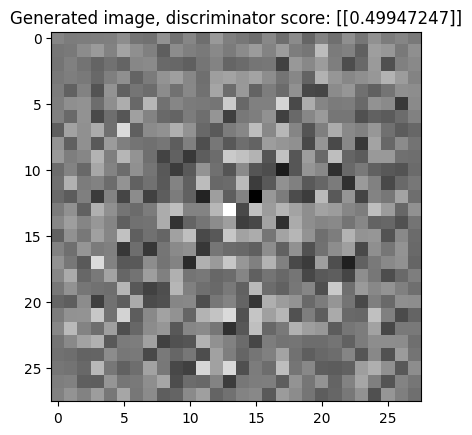

In [9]:
# Create optimizers
generator_optimizer = Adam(1e-4)
discriminator_optimizer = Adam(1e-4)

# Create both generator and discriminator models
generator = make_generator_model(LATENT_SPACE_SIZE)
discriminator = make_discriminator_model(H, W, 1)

# Create a noise vector (latent space) and generate an image based on it
noise = tf.random.normal([1, LATENT_SPACE_SIZE])
generated_image = generator(noise, training=False)

# Pass the generated image through the discriminator
decision = discriminator(generated_image)

# Show the generated image and the disciminator score
plt.imshow(tf.reshape(generated_image, (H, W)) * 127.5 + 127.2, cmap='gray')
plt.title(f'Generated image, discriminator score: {decision}')
plt.show()

In [10]:
# Print summaries of the networks
generator.summary()
discriminator.summary()

Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense (Dense)               (None, 12544)             1266944   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819328    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)        51

In [11]:
EPOCHS = 100
NUM_EXAMPLES_TO_GENERATE = 16

# This seed can be used to consistenly generate digits for visualization purposes
seed = tf.random.normal([NUM_EXAMPLES_TO_GENERATE, LATENT_SPACE_SIZE])

# Use of 'tf.function' causes the function to be compiled
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, LATENT_SPACE_SIZE])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training = True)
        
        real_output = discriminator(images, training = True)
        fake_output = discriminator(generated_images, training = True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [12]:
def train(dataset, epochs):
    
    fig, ax = plt.subplots(4, 4)
    fig.tight_layout()
    
    for epoch in range(epochs):
        start = time.time()
        
        # Iterate over the dataset and train for each image batch
        for image_batch in dataset:
            train_step(image_batch)
        
        # Show the generated images, based on the seed, every n:th epoch
        if(epoch + 1) % 10 == 0:
       
            # Note that training is set to False here.
            # This is done so that all layers run in inference mode, e.g. batchnorm
            generated_images = generator(seed, training = False)
            discriminator_scores = discriminator(generated_images, training = False)
            for i in range(16):
                discriminator_score = discriminator_scores[i].numpy().flatten()
                ax[int(math.floor(i/4)), i%4].imshow(tf.reshape(generated_images[i], (H, W)) * 127.5 + 127.5, cmap='gray')
                ax[int(math.floor(i/4)), i%4].set_title(f"Score: {np.array2string(discriminator_score, precision=2)}")
                ax[int(math.floor(i/4)), i%4].axis('off')
        
            display.clear_output(wait=True)
            display.display(matplotlib.pyplot.gcf())
            
        print(f'Time for epoch {epoch + 1} is {time.time()-start} sec')

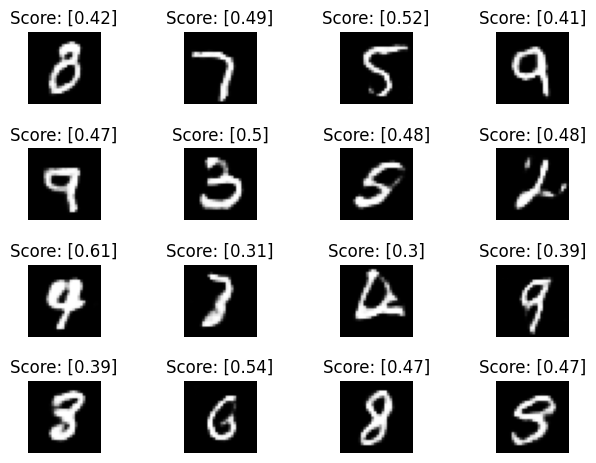

Time for epoch 100 is 10.916468858718872 sec


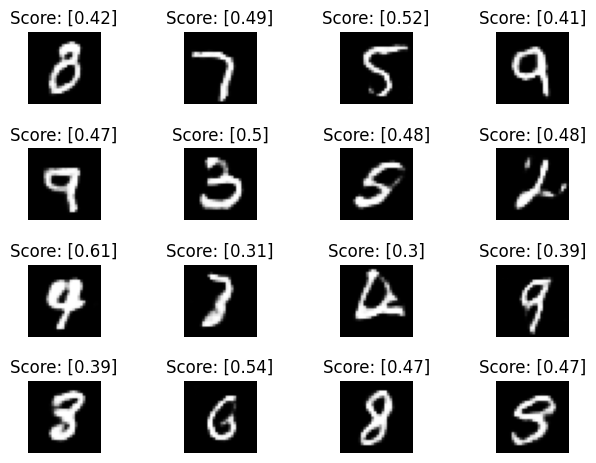

In [13]:
# Train for the number of epochs
train(train_dataset, EPOCHS)

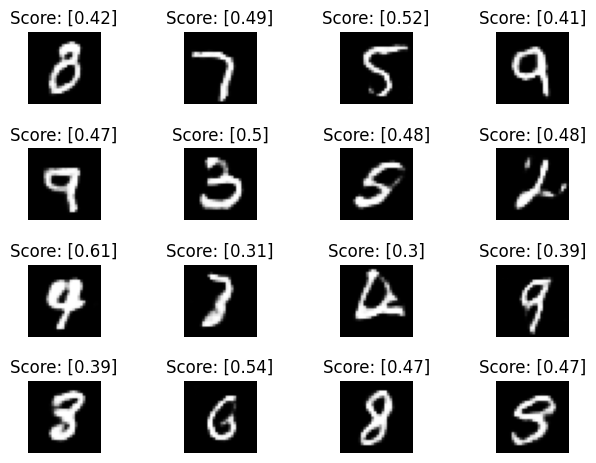

In [14]:
# Display random generated images and the corresponding discriminator scores
fig, ax = plt.subplots(4, 4)
fig.tight_layout()

generated_images = generator(seed, training=False)
discriminator_scores = discriminator(generated_images, training=False)
for i in range(16):
    discriminator_score = discriminator_scores[i].numpy().flatten()
    ax[int(math.floor(i/4)), i%4].imshow(tf.reshape(generated_images[i], (H, W)) * 127.5 + 127.5, cmap='gray')
    ax[int(math.floor(i/4)), i%4].set_title(f"Score: {np.array2string(discriminator_score, precision=2)}")
    ax[int(math.floor(i/4)), i%4].axis('off')

plt.show()